<a href="https://colab.research.google.com/github/PsorTheDoctor/pybullet/blob/master/mujoco/mujoco_lqr_humanoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MuJoCo: LQR controlled balancing humanoid
GPU is required.

In [ ]:
%pip install -q mujoco mediapy
%env MUJOCO_GL=egl

In [27]:
import mujoco
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg
import mediapy as media
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [ ]:
!git clone https://github.com/deepmind/mujoco
with open('mujoco/model/humanoid/humanoid.xml', 'r') as f:
  xml = f.read()

""

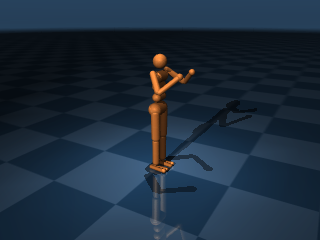

In [29]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

""

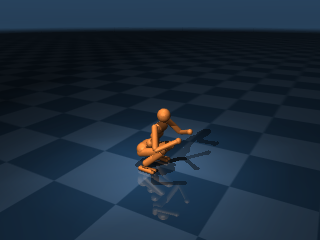

""

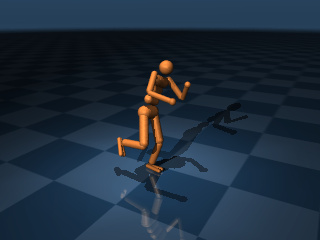

In [30]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [31]:
DURATION = 3
FRAMERATE = 60

# Make a new camera, move it to the closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2
mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  data.ctrl = np.random.randn(model.nu)  # Set control vector.
  mujoco.mj_step(model, data)  # Step the simulation.
  # Render and save the frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels.copy())

media.show_video(frames, fps=FRAMERATE)

##Stable standing on one leg
###Finding the control setpoint using inverse kinematics

In [32]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse)

[  0.      0.    275.879 -33.186   4.995  -6.688  -4.305   3.693 -15.451 -10.906   0.412  -1.613
  -9.793  -2.312  -0.366  -5.913  -0.417  -1.914   5.759   2.665  -0.202  -5.755   0.994   1.141
  -1.987   3.821   1.151]


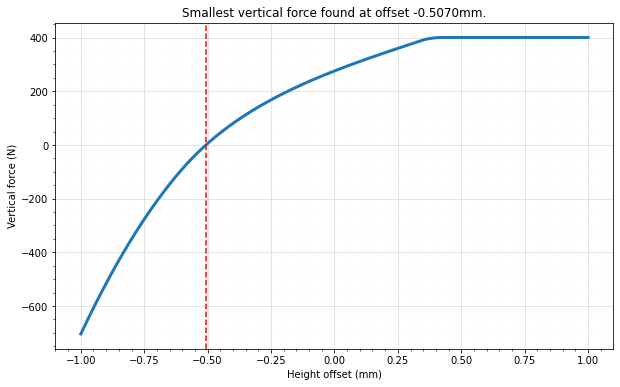

In [33]:
height_offsets = np.linspace(-0.001, 0.001, 2001)
vertical_forces = []
for offset in height_offsets:
  mujoco.mj_resetDataKeyframe(model, data, 1)
  mujoco.mj_forward(model, data)
  data.qacc = 0
  data.qpos[2] += offset  # Offset the height by `offset`.
  mujoco.mj_inverse(model, data)
  vertical_forces.append(data.qfrc_inverse[2])

# Find the height-offset at which the vertical force is smallest.
idx = np.argmin(np.abs(vertical_forces))
best_offset = height_offsets[idx]

plt.figure(figsize=(10, 6))
plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
plt.axvline(x=best_offset*1000, color='red', linestyle='--')
weight = model.body_subtreemass[1] * np.linalg.norm(model.opt.gravity)
plt.xlabel('Height offset (mm)')
plt.ylabel('Vertical force (N)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title(f'Smallest vertical force '
          f'found at offset {best_offset*1000:.4f}mm.')
plt.show()

In [34]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
data.qpos[2] += best_offset
qpos0 = data.qpos.copy()
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('Desired forces:', data.qfrc_inverse)

Desired forces: [  0.      0.     -0.191  -3.447   0.222  -0.817   2.586  14.637 -18.64  -10.906   0.412  -1.613
  -9.793  -2.312  -0.366 -23.755  -2.171  12.264  26.101  13.337  -0.113  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [35]:
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()
print('Conrol setpoint:', ctrl0)

Conrol setpoint: [ 0.366  0.065 -0.466 -0.273  0.01  -0.013 -0.122 -0.018 -0.116 -0.594 -0.054  0.102  0.326 -0.006
  0.667 -0.288  0.05   0.029 -0.099  0.191  0.029]


In [36]:
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('Actuator forces:', data.qfrc_actuator)

Actuator forces: [  0.      0.      0.      0.      0.      0.      2.586  14.637 -18.64  -10.906   0.412  -1.613
  -9.793  -2.312  -0.366 -23.755  -2.171  12.264  26.101  13.337  -0.113  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [37]:
# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

frames = []
while data.time < DURATION:
  mujoco.mj_step(model, data)  # Step the simulation.
  # Render and save the frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels.copy())

media.show_video(frames, fps=FRAMERATE)

###Chosing the *Q* and *R* matrices

In [38]:
nu = model.nu  # Alias for the number of actuators.
R = np.eye(nu)
nv = model.nv  # Shortcut for the number of DoFs.

# Get the Jacobian for the root body (torso) CoM.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
mujoco.mj_forward(model, data)
jac_com = np.zeros((3, nv))
mujoco.mj_jacSubtreeCom(model, data, jac_com, model.body('torso').id)

# Get the Jacobian for the left foot.
jac_foot = np.zeros((3, nv))
mujoco.mj_jacBodyCom(model, data, jac_foot, None, model.body('foot_left').id)

jac_diff = jac_com - jac_foot
Qbalance = jac_diff.T @ jac_diff

In [39]:
joint_names = [model.joint(i).name for i in range(model.njnt)]
root_dofs = range(6)
body_dofs = range(6, nv)
abdomen_dofs = [
    model.joint(name).dofadr[0] for name in joint_names if 'abdomen' in name 
    and not 'z' in name
]
left_leg_dofs = [
    model.joint(name).dofadr[0] for name in joint_names if 'left' in name 
    and ('hip' in name or 'knee' in name or 'ankle' in name) and not 'z' in name
]
balance_dofs = abdomen_dofs + left_leg_dofs
other_dofs = np.setdiff1d(body_dofs, balance_dofs)

In [40]:
BALANCE_COST = 1000
BALANCE_JOINT_COST = 3
OTHER_JOINT_COST = .3

Qjoint = np.eye(nv)
Qjoint[root_dofs, root_dofs] *= 0
Qjoint[balance_dofs, balance_dofs] *= BALANCE_JOINT_COST
Qjoint[other_dofs, other_dofs] *= OTHER_JOINT_COST

Qpos = BALANCE_COST * Qbalance + Qjoint
Q = np.block([[Qpos, np.zeros((nv, nv))], [np.zeros((nv, 2*nv))]])

###Computing the LQR gain and *K* matrix

In [41]:
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

A = np.zeros((2 * nv, 2 * nv))
B = np.zeros((2 * nv, nu))
epsilon = 1e-6
centered = True
mujoco.mjd_transitionFD(model, data, epsilon, centered, A, B, None, None)

In [42]:
P = scipy.linalg.solve_discrete_are(A, B, Q, R)
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

###Stable standing

In [43]:
# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

dq = np.zeros(model.nv)

frames = []
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T 

  data.ctrl = ctrl0 - K @ dx  # LQR control law.
  mujoco.mj_step(model, data)  # Step the simulation.
  # Render and save the frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels.copy())

media.show_video(frames, fps=FRAMERATE)

###Final video

In [45]:
DURATION = 5
ROTATION = 15
CTRL_STD = 0.05
CTRL_RATE = 0.8

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2.3

# Enable contact force visualisation.
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

model.vis.map.force = 0.01

def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time * 2 * np.pi)

def azimuth(time: float) -> float:
  return 100 + unit_smooth(data.time / DURATION) * ROTATION

# Precompute some noise.
np.random.seed(1)
nsteps = int(np.ceil(DURATION / model.opt.timestep))
perturb = np.random.randn(nsteps, nu)

# Smooth the noise.
width = int(nsteps * CTRL_RATE / DURATION)
kernel = np.exp(-0.5 * np.linspace(-3, 3, width)**2)
kernel /= np.linalg.norm(kernel)
for i in range(nu):
  perturb[:, i] = np.convolve(perturb[:, 1], kernel, mode='same')

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

renderer = mujoco.Renderer(model, width=1280, height=720)

frames = []
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T 

  data.ctrl = ctrl0 - K @ dx  # LQR control law.
  mujoco.mj_step(model, data)  # Step the simulation.
  # Render and save the frames.
  if len(frames) < data.time * FRAMERATE:
    camera.azimuth = azimuth(data.time)
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels.copy())

media.show_video(frames, fps=FRAMERATE)